# Basic Settings

In [1]:
### 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf
# 설치 후 colab의 경우 Runtime > Restart session 필요

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='NanumBarunGothic') # 혹은 다른 설치한 Nanum 폰트 사용

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy
import scipy.stats as stats

# 자녀 유/무와 근로 유/무 상관관계

## 분석 목적 : 자녀의 유/무가 근로 유/무와 상관관계가 있는지 분석

## 분석 방향
1. 기혼 여성의 근로 유/무 확인
2. 자녀의 유/무와 근로 유/무 상관관계 확인



### data 불러오기

In [4]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [94]:
# 출산율 data 불러오기

# CSV 파일 경로 지정
file_path01 = '/content/drive/MyDrive/천안_공공데이터_활용_정책제안/경제활동상태별_출생자녀수별_기혼여성인구_15세이상_시군구_20240802160508.csv'

# CSV 파일을 DataFrame으로 읽어오기
df_work_baby = pd.read_csv(file_path01, encoding='euc-kr')
df_work_baby

,행정구역별(시군구),경제활동상태별,항목,시점,데이터
0,전국,계,기혼여성(15세 이상)-계,2020,16548926
1,전국,계,출생자녀 0명,2020,1393451
2,전국,계,출생자녀 1명,2020,3122017
3,전국,계,출생자녀 2명,2020,7889838
4,전국,계,출생자녀 3명,2020,2476983
...,...,...,...,...,...
751,제주특별자치도,일하지않았음,출생자녀 8명,2020,598
752,제주특별자치도,일하지않았음,출생자녀 9명,2020,269
753,제주특별자치도,일하지않았음,출생자녀 10명이상,2020,106
754,제주특별자치도,일하지않았음,총 출생 자녀 수,2020,223112


# 데이터 전처리

In [95]:
df_work_baby.loc[(df_work_baby['항목'] != '기혼여성(15세 이상)-계')&(df_work_baby['항목'] != '출생자녀 0명')&(df_work_baby['항목'] != '총 출생 자녀 수')&(df_work_baby['항목'] != '평균 출생 자녀 수'),'자녀유무'] = '있음'
df_work_baby.loc[(df_work_baby['항목'] == '출생자녀 0명'),'자녀유무'] = '없음'

In [96]:
df_work_baby

,행정구역별(시군구),경제활동상태별,항목,시점,데이터,자녀유무
0,전국,계,기혼여성(15세 이상)-계,2020,16548926,na
1,전국,계,출생자녀 0명,2020,1393451,없음
2,전국,계,출생자녀 1명,2020,3122017,있음
3,전국,계,출생자녀 2명,2020,7889838,있음
4,전국,계,출생자녀 3명,2020,2476983,있음
...,...,...,...,...,...,...
751,제주특별자치도,일하지않았음,출생자녀 8명,2020,598,있음
752,제주특별자치도,일하지않았음,출생자녀 9명,2020,269,있음
753,제주특별자치도,일하지않았음,출생자녀 10명이상,2020,106,있음
754,제주특별자치도,일하지않았음,총 출생 자녀 수,2020,223112,na


In [97]:
df_work_baby = df_work_baby.loc[(df_work_baby['자녀유무']!='na')]
df_work_baby['데이터'] = df_work_baby['데이터'].replace('-',0).astype(int)
df_work_baby = df_work_baby.groupby(['행정구역별(시군구)','경제활동상태별','자녀유무'])['데이터'].sum().reset_index()

<ipython-input-97-21fbdf301326>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work_baby['데이터'] = df_work_baby['데이터'].replace('-',0).astype(int)


In [98]:
df_work_baby = pd.pivot_table(df_work_baby,index=['행정구역별(시군구)','자녀유무'],columns='경제활동상태별',values='데이터').reset_index()
df_work_baby['일한비율'] = df_work_baby['일하였음']/(df_work_baby['계'])
df_work_baby.to_csv('df_work_baby.csv',index=False)

# 지역별 자녀 유/무에 따른 일한 비율 비교

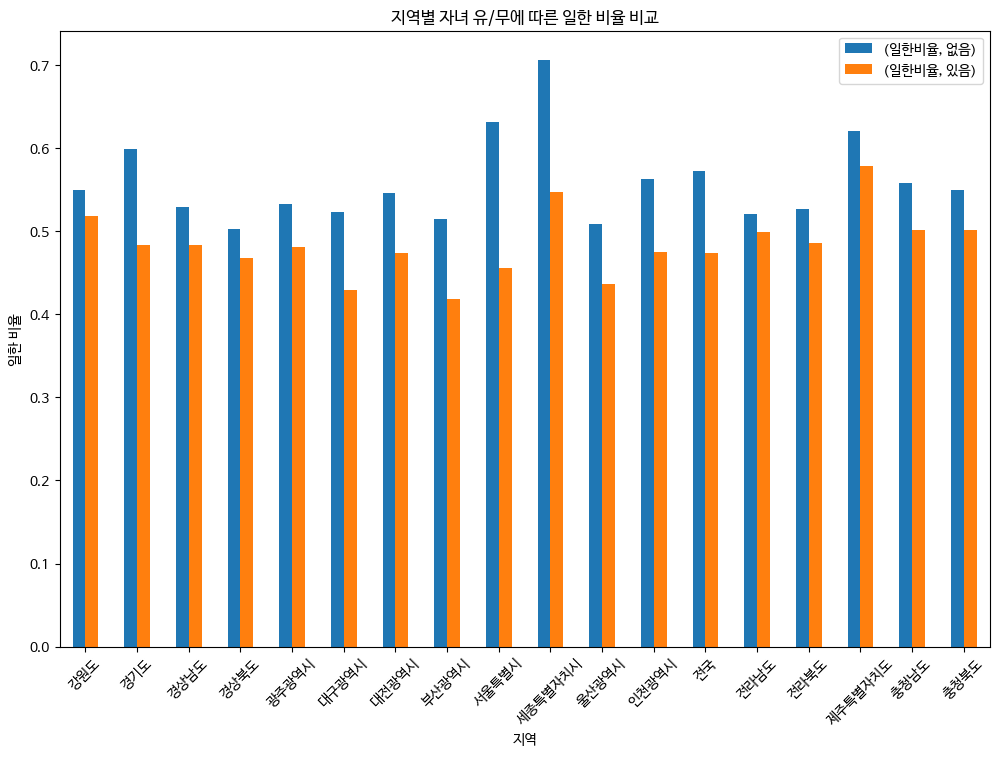

In [92]:
df_pivot = pd.pivot_table(df_work_baby,index='행정구역별(시군구)',columns = ['자녀유무'],values=['일한비율'])
df_pivot.plot(kind='bar',figsize=(12,8))
plt.xlabel('지역')
plt.ylabel('일한 비율')
plt.title('지역별 자녀 유/무에 따른 일한 비율 비교')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


# 결론
- 전체적으로 자녀가 없는 기혼부부에서 경제활동을 더 많이 하고 있음.
- 하지만 자녀의 유/무에 따른 차이가 크지 않음.